In [3]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [290]:
torch.manual_seed(0)
np.random.seed(0)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=7, stride=1, padding=3)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
    
        pred = self.conv1(input)
        pred = self.bn1(self.act(pred))
        layer1 = pred.clone()
        
        pred = self.conv2(pred)
        pred = self.bn2(self.act(pred))
        layer2 = pred.clone()
        
        pred = self.conv3(pred)
        pred = self.bn3(self.act(pred))
        
        pred, indices = self.maxpool(pred)
        pred = self.unpool(pred, indices)
        maxlayer = pred.clone()
    
        pred = self.conv4(pred)
        pred = self.bn4(self.act(pred))
        
        pred = self.conv5(pred)
        pred = self.bn5(self.act(pred))
        layer5 = pred.clone()
        
        pred = self.conv6(pred)
        
        return layer1, layer2, maxlayer, layer5, pred




In [292]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [293]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

num_folds = 5
fold_num = 1
train, test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [294]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [312]:
model = Net()

loss_fn = nn.L1Loss()
# loss_fn = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('dr')
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

In [313]:
test_pred = {}
for epoch in range(20000):
    
    layer1, layer2, maxlayer, layer5, pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss1 = loss_fn(pred, out)
    loss2 = 0.001*l1_penalty(pred)
    loss = loss1
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %1000 == 0:
        
        
        test_layer1, test_layer2, test_maxlayer, test_layer5, test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])
        
        test_pred[epoch] = test_pr.cpu().data.numpy()

0 Training Error: 68.72335052490234 Test Error: 65.00340270996094
1000 Training Error: 23.867414474487305 Test Error: 73.61677551269531
2000 Training Error: 19.164287567138672 Test Error: 77.29220581054688
3000 Training Error: 38.16445541381836 Test Error: 78.11471557617188
4000 Training Error: 12.51691722869873 Test Error: 79.61851501464844
5000 Training Error: 26.34412384033203 Test Error: 74.03479766845703
6000 Training Error: 16.200206756591797 Test Error: 81.59984588623047
7000 Training Error: 18.65424919128418 Test Error: 79.04327392578125
8000 Training Error: 23.56060218811035 Test Error: 94.76358032226562
9000 Training Error: 10.338059425354004 Test Error: 82.53526306152344
10000 Training Error: 21.468891143798828 Test Error: 84.42156219482422
11000 Training Error: 12.033474922180176 Test Error: 86.53825378417969
12000 Training Error: 16.965930938720703 Test Error: 82.79837799072266
13000 Training Error: 20.140348434448242 Test Error: 82.47594451904297
14000 Training Error: 11.

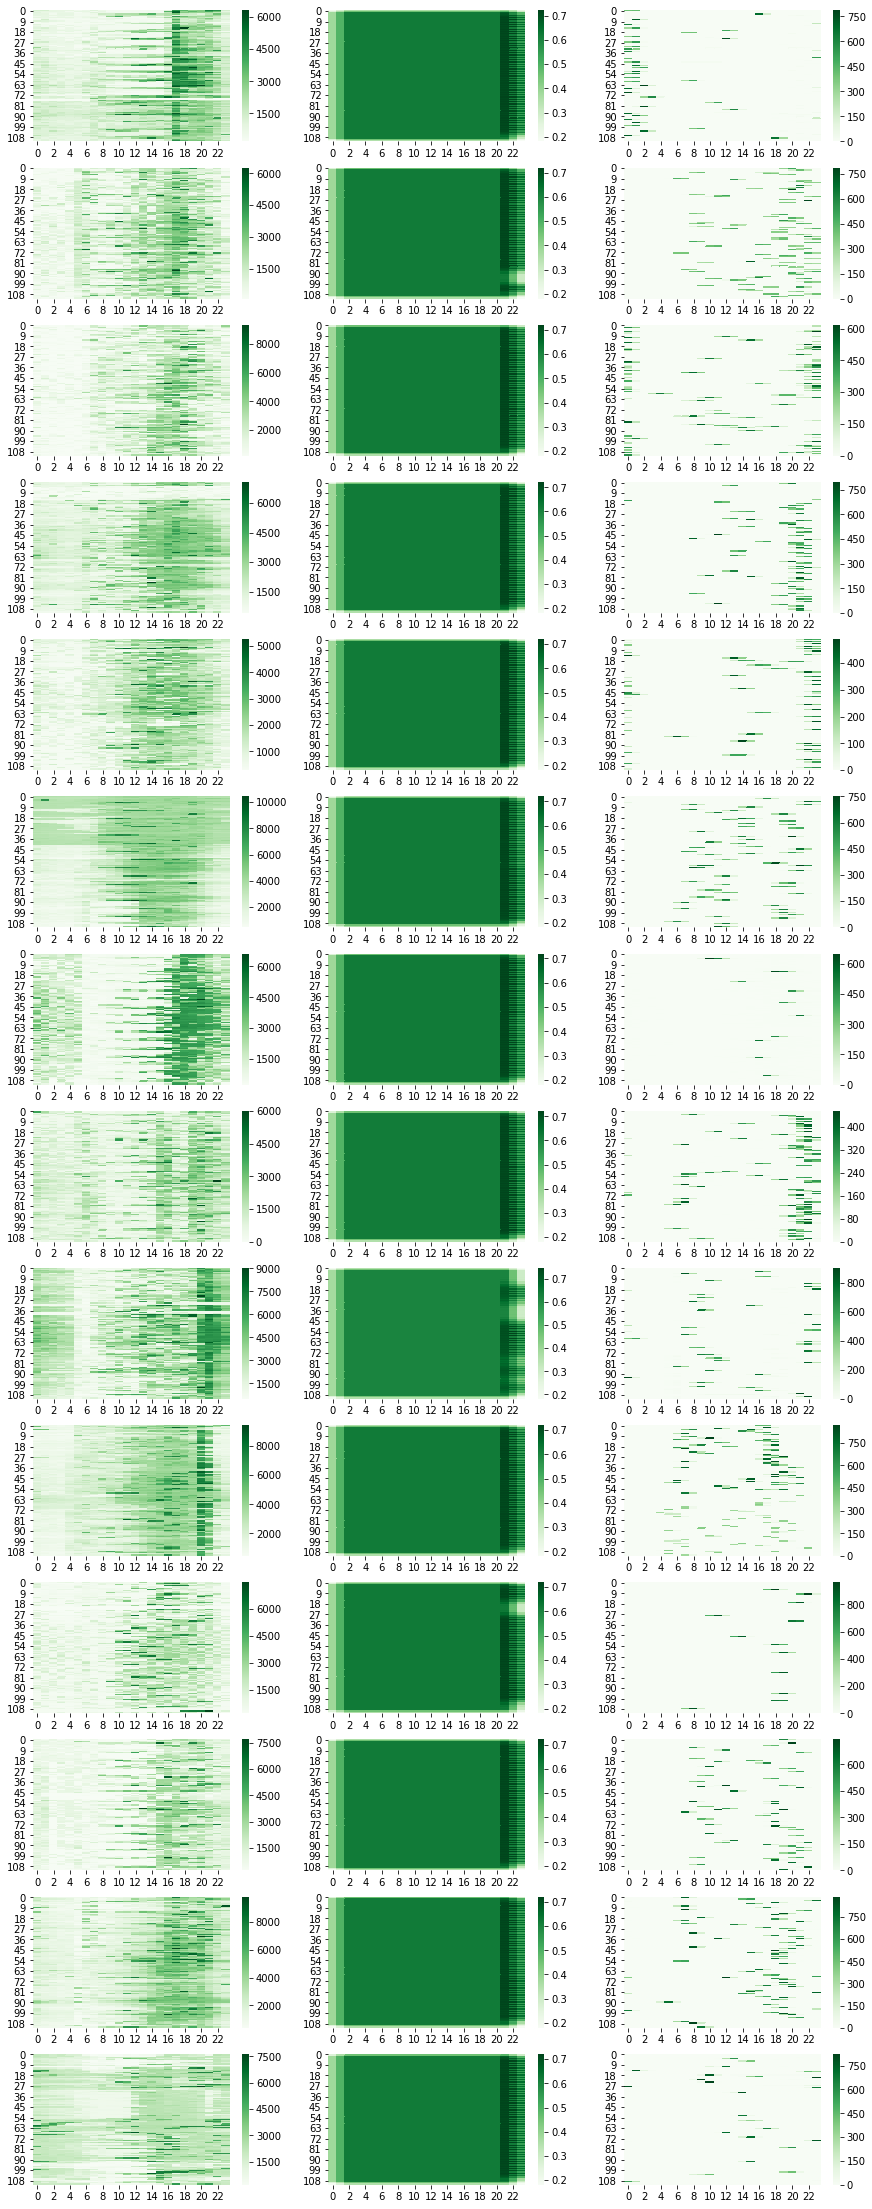

In [311]:
num_test = test_pr.cpu().data.numpy().shape[0]
# print(num_test)
#     iters=3000
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])



In [239]:
for i in range(14):
    for j in range(16):
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        sns.heatmap(pd.DataFrame(test_layer2.cpu().data.numpy()[i][j]), cmap='Greens')
        fig.savefig('./layeroutput/test_layer_2_{}-{}.png'.format(i, j))   # save the figure to file
        plt.close(fig) 

In [45]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

In [ ]:
for iters in range(1000, 200000, 1000):
    num_test = test_pr.cpu().data.numpy().shape[0]
    # print(num_test)
#     iters=3000
    fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
    ax = axes.flatten()

    # pred = test_pr.cpu().data.numpy()
    # print(pred.shape)
    # print(pred[0][0].shape)


    for i in range(num_test):
        sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
        sns.heatmap(pd.DataFrame(test_pred[iters][i][0]), cmap='Greens', ax=axes[i, 1])
        sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])

    plt.savefig("./test_{}.png".format(iters))

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

43


IndexError: index 9 is out of bounds for axis 0 with size 9

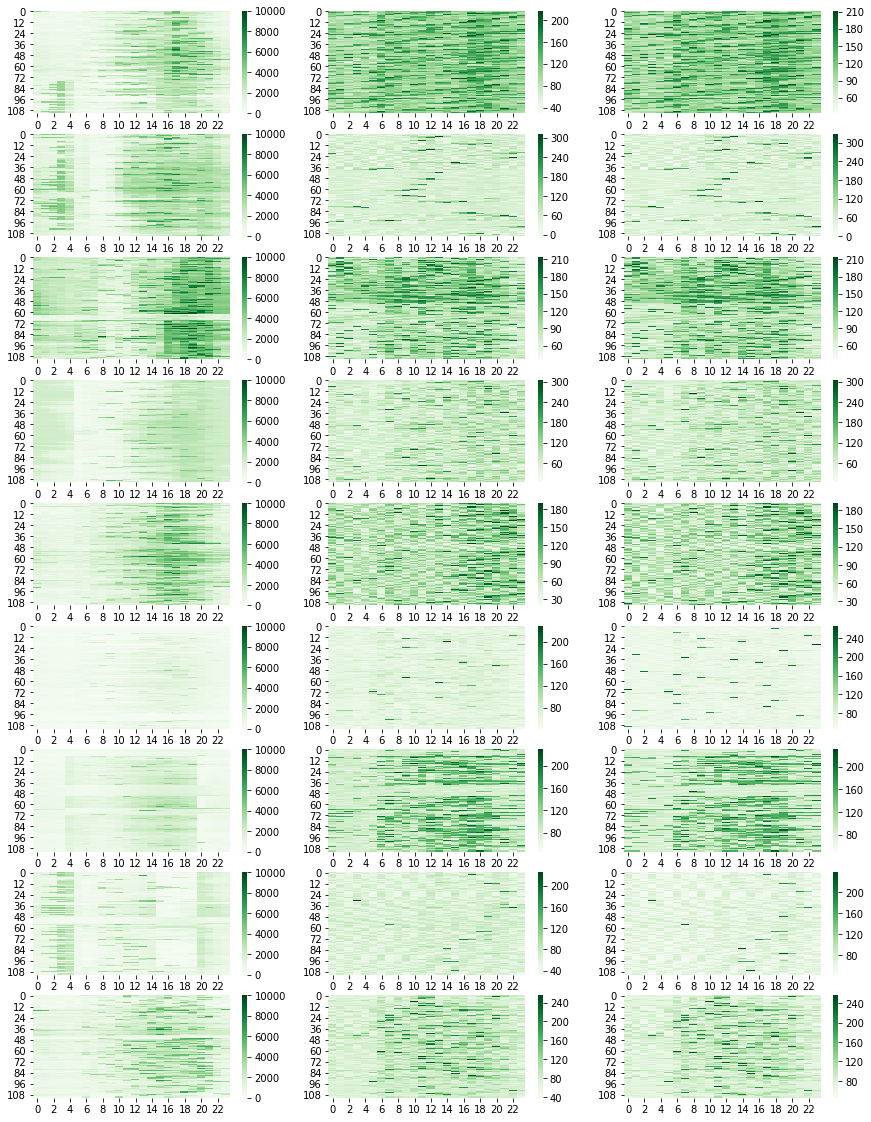

In [303]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




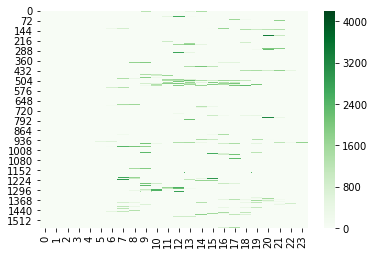

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')